In [1]:
from os import listdir
from os.path import isdir
from PIL import Image
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from numpy import load
from numpy import expand_dims
from keras.models import load_model
from random import choice
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 

Using TensorFlow backend.


In [2]:
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

In [3]:
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path)
        # store
        faces.append(face)
    return faces

In [4]:
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

In [5]:
trainX, trainy = load_dataset('datasets/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('datasets/validation/')
# save arrays to one file in compressed format
savez_compressed('cinema_class.npz', trainX, trainy, testX, testy)

>loaded 15 examples for class: Adrian Broody
>loaded 16 examples for class: Adriana Barazza
>loaded 16 examples for class: Ali Latter
>loaded 7 examples for class: Amena Khan
>loaded 16 examples for class: Andrew Lincolen
>loaded 16 examples for class: Angella Basset
>loaded 10 examples for class: Anna_Hathaway
>loaded 14 examples for class: Anthony Hopkins
>loaded 18 examples for class: arnold_schwarzenegger
>loaded 16 examples for class: Aron Judge
>loaded 16 examples for class: Aron Paul
>loaded 10 examples for class: Barabara Palvin
>loaded 15 examples for class: Barbra Streisand
>loaded 16 examples for class: Barry Pepper
>loaded 16 examples for class: Bella Hadid
>loaded 32 examples for class: bella thorne
>loaded 14 examples for class: ben_afflek
>loaded 14 examples for class: Beyonce Knowles
>loaded 11 examples for class: Buffon
>loaded 10 examples for class: De_Niro
>loaded 11 examples for class: Donnie Yen
>loaded 15 examples for class: dwayne_johnson
>loaded 17 examples for 

In [6]:
test_1, ytest_1 = load_dataset('datasets/test/')
print(test_1.shape, ytest_1.shape)
savez_compressed('test_1.npz', test_1, ytest_1)

>loaded 156 examples for class: test
(156, 160, 160, 3) (156,)


# Create the embedding for the dataset 

In [7]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [8]:
# load the face dataset
data = load('cinema_class.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')

Loaded:  (455, 160, 160, 3) (455,) (174, 160, 160, 3) (174,)
Loaded Model


C:\Users\mosta\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

(455, 128)


In [10]:
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

(174, 128)


In [11]:
# save arrays to one file in compressed format
savez_compressed('cinema_class_embeddings.npz', newTrainX, trainy, newTestX, testy)

In [12]:
# load the face dataset
data = load('test_1.npz')
test_1, ytest_1 = data['arr_0'], data['arr_1']
print('Loaded: ', test_1.shape, ytest_1.shape)

Loaded:  (156, 160, 160, 3) (156,)


In [13]:
i_test = list()
for face_pixels in test_1:
    embedding = get_embedding(model, face_pixels)
    i_test.append(embedding)
newTrainX = asarray(i_test)
print(newTrainX.shape)

(156, 128)


In [14]:
savez_compressed('test_1_embeddings.npz', i_test, ytest_1)

# Train the model 

In [15]:
# load dataset
data = load('cinema_class_embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors

Dataset: train=455, test=174


In [16]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

In [17]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [18]:
# fit model

svc = SVC(kernel='rbf',gamma=0.7,probability=True).fit(trainX, trainy)
yhat_train = svc.predict(trainX)
yhat_test = svc.predict(testX)
yhat_prob = svc.predict_proba(testX)

In [42]:
score_test = accuracy_score(testy, yhat_test)
print( score_test)

0.9942528735632183


In [20]:

filename = 'finalized_model.pkl'
pickle.dump(svc, open(filename, 'wb'))

# Calculate FFR, FAR and EER

In [21]:
# Load the test dataset for Both original and imposter 
data_gen = load('cinema_class.npz')
data_imposter= load('test_1.npz')
testX_imposter_faces = data_imposter['arr_0']
test_X_gen_faces = data_gen['arr_2']
print(test_X_gen_faces.shape)
print(testX_imposter_faces.shape)

(174, 160, 160, 3)
(156, 160, 160, 3)


In [22]:
# load face embeddings
data_imposter = load("test_1_embeddings.npz")
data_gen = load('cinema_class_embeddings.npz')
trainX_gen, trainy_gen, testX_gen, testy_gen = data_gen['arr_0'], data_gen['arr_1'],data_gen['arr_2'],data_gen['arr_3']
testX_imposter, testy_imposter = data_imposter['arr_0'], data_imposter['arr_1']
print(testX_gen.shape)
print(testX_imposter.shape)

(174, 128)
(156, 128)


In [23]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX_gen = in_encoder.transform(trainX_gen)
testX_imposter = in_encoder.transform(testX_imposter)
testX_gen = in_encoder.transform(testX_gen)

In [24]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy_gen)
trainy_gen = out_encoder.transform(trainy_gen)
testy_gen=out_encoder.transform(testy_gen)
# fit model
model = pickle.load(open('finalized_model.pkl', 'rb'))
model.fit(trainX_gen, trainy_gen)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.7, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [25]:
# test model on imposter faces 
# a is a list where we will calculate the probability of the false accptance rate FAR
# the model will predect the face and then check the matching probablity and add it to the a list  

a = []
for i in range(100):
        random_face_pixels = testX_imposter_faces[i]
        random_face_emb = testX_imposter[i]
        random_face_class = testy_imposter[i]
        samples = expand_dims(random_face_emb, axis=0)
        yhat_class = model.predict(samples)
        yhat_prob = model.predict_proba(samples)
        class_index = yhat_class[0]
        class_probability = yhat_prob[0,class_index] * 100
        intp = int((class_probability))
        #print(f'Predicted: {intp} %')
        a.append(intp)

In [26]:
# far is a list that we will save the False accaptance rate in each threshold 
 # threshold is the list of thresold and it will go from 0% to 100%       
far = []
threshold = []
for i in range(100):
        num = 0

        for x in a:
                if x>i:
                        num+=1
        #print(i,num)
        far.append(num)
        threshold.append(i)

far = np.array(far)
print('FAR: ',far)
print('-----------------------------------------------------------')


FAR:  [100 100 100 100  99  89  70  50  37  25  13   8   4   3   3   2   1   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
-----------------------------------------------------------


In [27]:
b = []
for i in range(100):
        random_face_pixels = test_X_gen_faces[i]
        random_face_emb = testX_gen[i]
        random_face_class = testy_gen[i]
        face_name = out_encoder.inverse_transform([random_face_class])
        # prediction for the face
        samples = expand_dims(random_face_emb, axis=0)
        yhat_class = model.predict(samples)
        yhat_prob = model.predict_proba(samples)
        # get name
        class_index = yhat_class[0]
        class_probability = yhat_prob[0,class_index] * 100
        predict_threshold = out_encoder.inverse_transform(yhat_class)
        if predict_threshold[0]==face_name[0]:
                intp = int((class_probability))
                #print(f'Predicted: {intp} %')
                b.append(intp)
print(b)

[39, 42, 29, 20, 38, 25, 39, 11, 20, 41, 27, 31, 39, 18, 25, 16, 24, 39, 25, 38, 45, 21, 35, 29, 38, 27, 34, 21, 29, 19, 28, 17, 27, 18, 33, 26, 45, 42, 46, 35, 18, 26, 44, 35, 36, 23, 30, 34, 35, 54, 48, 27, 50, 42, 36, 33, 29, 41, 31, 27, 21, 33, 34, 48, 44, 39, 39, 46, 36, 47, 47, 46, 45, 43, 38, 52, 38, 47, 51, 44, 45, 35, 32, 62, 56, 55, 67, 55, 65, 66, 54, 49, 59, 42, 24, 49, 29, 40, 39]


In [28]:
frr = []
for i in range(100):
        num = 0

        for x in b:
                if x<i:
                        num+=1
        #print(i,num)
        frr.append(num)


frr = np.array(frr)
print('FRR: ',frr)
print('-----------------------------------------------------------')


FRR:  [ 0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  2  3  6  7  9 12 12
 13 15 18 20 25 26 31 32 34 35 38 41 46 49 49 54 61 62 64 68 69 72 76 79
 82 84 86 87 88 89 89 91 93 94 94 94 95 95 95 96 96 96 97 98 99 99 99 99
 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99
 99 99 99 99]
-----------------------------------------------------------


In [29]:
# calculate the EER
for i  in range(100):
        a = frr[i]
        b = far[i]
        if a == b:
                EER= a
                print('EER = ',i)


EER =  16


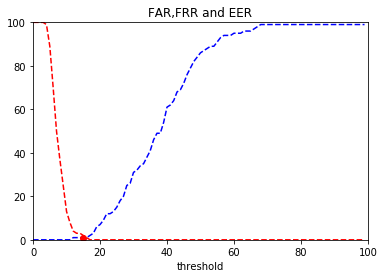

In [30]:
plt.plot(threshold,frr,'--b',far,'--r')
plt.plot(15,EER,'ro') 

plt.xlabel('threshold')
plt.title('FAR,FRR and EER')
plt.axis([0, 100, 0, 100])
plt.show()

In [31]:
threshold = np.array(threshold)

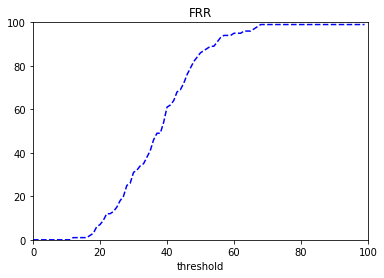

In [32]:
plt.plot(threshold,frr,'--b')
plt.xlabel('threshold')
plt.title('FRR')
plt.axis([0, 100, 0, 100])
plt.show()


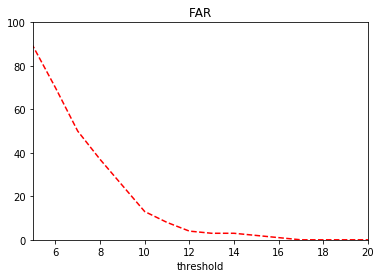

In [33]:
plt.plot(threshold,far,'--r')
plt.xlabel('threshold')
plt.title('FAR')

plt.axis([5, 20, 0, 100])
plt.show()

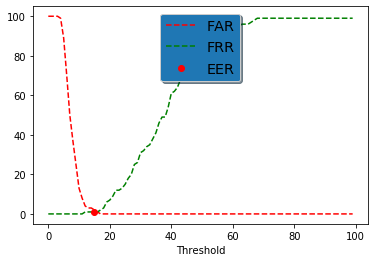

In [34]:
fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.plot(15,EER,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [35]:
import jovian

<IPython.core.display.Javascript object>

[jovian] Update Available: 0.2.11 --> 0.2.16
[jovian] Run `!pip install jovian --upgrade` to upgrade


In [38]:
!pip install jovian --upgrade

  Attempting uninstall: jovian
    Found existing installation: jovian 0.2.11
    Uninstalling jovian-0.2.11:
      Successfully uninstalled jovian-0.2.11


In [41]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "mustafaazzurr/face-recognition-farfrr-and-eer" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/mustafaazzurr/face-recognition-farfrr-and-eer
